In [1]:
import numpy as np
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd

from plotting import validation_plot, COLOR_PRS, COLOR_RRS, COLOR_ALPHAFOLD_ROSETTAFOLD
from datasets import (load_y2h_pairwise_test,
                      load_additional_y2h_pairwise_test,
                      load_AlphaFold_RoseTTAFold,
                      load_all_orfs)



In [2]:
plt.show()
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
s07 = load_y2h_pairwise_test(remove_homodimers=True)
s08 = load_additional_y2h_pairwise_test(remove_homodimers=True)
afrf = load_AlphaFold_RoseTTAFold(restrict_to_high_confidence=False)


s07_pairs = set(s07['pair'].unique())
s08_afrf_pairs = set(s08.loc[s08['source_dataset'] == 'AlphaFold+RoseTTAFold', 'pair'].unique())
orfeome = pd.read_csv('../data/internal/ORF-search-space_YeRI.tsv', sep='\t')
db_aa = set(orfeome.loc[~orfeome['screened_as_DB'], 'orf_name'].values)
ad_aa = set(orfeome.loc[~orfeome['screened_as_AD'], 'orf_name'].values)


def get_experiment(pair):
    if pair in s07_pairs:
        return 'S07'
    elif pair in s08_afrf_pairs:
        return 'YS08'
    elif any(x not in orfeome['orf_name'].values for x in pair.split('_')):
        return 'Not tested - ORF not in ORFeome collection'
    elif any(x in db_aa for x in pair.split('_')):
        return 'YS08'
    elif any(x in ad_aa for x in pair.split('_')):
        return 'YS08'
    else:
        return 'Not tested -- unknown reason'


def get_result(pair):
    if pair in s07_pairs:
        return s07.loc[s07['pair'] == pair, 'result'].unique()[0]
    elif pair in s08_afrf_pairs:
        return s08.loc[(s08['source_dataset'] == 'AlphaFold+RoseTTAFold') &
                       (s08['pair'] == pair), 'result'].values[0]
    elif any(x not in orfeome['orf_name'].values for x in pair.split('_')):
        return 'Not tested - ORF not in ORFeome collection'
    elif any(x in db_aa for x in pair.split('_')):
        return 'Not tested - DB autoactivator'
    elif any(x in ad_aa for x in pair.split('_')):
        return 'Not tested - AD autoactivator'
    else:
        return 'Not tested -- unknown reason'


def get_s07_source_datasets(pair):
    if pair in s07_pairs:
        return '/'.join(s07.loc[s07['pair'] == pair, 'source_dataset'].unique())
    else:
        return np.nan


afrf['Y2H_experiment'] = afrf.index.map(get_experiment)
afrf['Y2H_v4_result'] = afrf.index.map(get_result)
afrf['Y2H_v4_result'] = afrf['Y2H_v4_result'].fillna('either de novo autoactivator or the spotting failed')
afrf['Y2H_v4_result'] = afrf['Y2H_v4_result'].map(lambda x: 'Positive' if x == True else 'Negative' if x == False else x)
afrf['S07_source_datasets'] = afrf.index.map(get_s07_source_datasets)


In [ ]:
# Weighted average PRS rate of two Y2H v4 experiments

# Weight by number of AF/RF positives in each experiment
# (not the number of pairs tested) since these are not random samples.
# The first experiment is enriched for likely positives 
# (i.e. due to presence in other datasets). 
# Exclude pairs from YeRI in the first experiment, since these are
# by definition positive (it's the pairwise confirmation of screen hits).
# RRS is zero in both experiments so no need to do anything there.
n_in_YeRI_only = (afrf.loc[afrf['Y2H_experiment'] == 'S07', 'S07_source_datasets'] == 'YeRI').sum()
n_positive_S07 = (afrf.loc[afrf['Y2H_experiment'] == 'S07', 
                           'Y2H_v4_result'] == 'Positive').sum()
n_positive_S07 -= n_in_YeRI_only
n_tested_S07 = (afrf.loc[afrf['Y2H_experiment'] == 'S07',
                         'Y2H_v4_result'].isin(['Negative', 'Positive'])).sum()
n_tested_S07 -= n_in_YeRI_only
n_positive_S08 = (afrf.loc[afrf['Y2H_experiment'] == 'YS08', 
                           'Y2H_v4_result'] == 'Positive').sum()
n_tested_S08 = (afrf.loc[afrf['Y2H_experiment'] == 'YS08',
                         'Y2H_v4_result'].isin(['Negative', 'Positive'])).sum()
n_PRS_positive_S07 = (s07.loc[s07['source_dataset'] == 'scPRS-v2', 'result'] == True).sum()
n_PRS_tested_S07 = (s07.loc[s07['source_dataset'] == 'scPRS-v2', 'result'].notnull()).sum()
n_PRS_positive_S08 = (s08.loc[s08['source_dataset'] == 'scPRS-v2', 'result'] == True).sum()
n_PRS_tested_S08 = (s08.loc[s08['source_dataset'] == 'scPRS-v2', 'result'].notnull()).sum()
n_RRS_positive_S07 = (s07.loc[s07['source_dataset'] == 'scRRS-v2', 'result'] == True).sum()
n_RRS_positive_S08 = (s08.loc[s08['source_dataset'] == 'scRRS-v2', 'result'] == True).sum()
n_RRS_tested_S07 = (s07.loc[s07['source_dataset'] == 'scRRS-v2', 'result'].notnull()).sum()
n_RRS_tested_S08 = (s08.loc[s08['source_dataset'] == 'scRRS-v2', 'result'].notnull()).sum()

PRS_rate_S07 = n_PRS_positive_S07 / n_PRS_tested_S07
PRS_rate_S08 = n_PRS_positive_S08 / n_PRS_tested_S08
PRS_combined_rate = (n_positive_S07 + n_positive_S08) / (n_positive_S07 / PRS_rate_S07 + n_positive_S08 / PRS_rate_S08)

print('S07 PRS rate {:.1%}'.format(n_PRS_positive_S07 / n_PRS_tested_S07))
print('S08 PRS rate {:.1%}'.format(n_PRS_positive_S08 / n_PRS_tested_S08))
print('Combined PRS rate {:.1%}'.format(PRS_combined_rate))

S07 PRS rate 19.1%
S08 PRS rate 22.6%
Combined PRS rate 19.4%


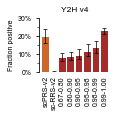

In [5]:
bins = [(afrf['PPI Score'].min(), 0.8),
        (0.8, 0.9),
        (0.9, 0.95),
        (0.95, 0.98),
        (0.98, 0.99),
        (0.99, 1.)]

# find pairs with low confidence
ns = [((afrf['PPI Score'] > a) & (afrf['PPI Score'] <= b) &
                   (afrf['S07_source_datasets'] != 'YeRI') &
                   afrf['Y2H_v4_result'].isin(['Negative', 'Positive'])).sum() for a, b in bins]
ps = [((afrf['PPI Score'] > a) & (afrf['PPI Score'] <= b) &
                   (afrf['S07_source_datasets'] != 'YeRI') &
                   (afrf['Y2H_v4_result'] == 'Positive')).sum() for a, b in bins]


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.3, h=1)
validation_plot(positives=[PRS_combined_rate * min([n_PRS_tested_S07, n_PRS_tested_S08]),
                           0] + ps,
                n_tested=[min([n_PRS_tested_S07, n_PRS_tested_S08]),
                          min([n_RRS_tested_S07, n_RRS_tested_S08])] + ns,
                draw_numbers=False,
                labels=['scPRS-v2', 'sc-RRS-v2'] + ['{:.2f}-{:.2f}'.format(a, b) for (a, b) in bins],
                y_max=0.3,
                colors=[COLOR_PRS, COLOR_RRS] + [COLOR_ALPHAFOLD_ROSETTAFOLD] * len(bins),
                xlabel_rotation=90,
                errorbar_capsize=0.5,
                errorbar_thickness=0.7,
                ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_facecolor('white')
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
ax.set_title('Y2H v4')
fig.savefig('../figures/S07-plus-S08-merge_confidence-binned_AlphFoldRoseTTAFold.pdf',
            bbox_inches='tight')


In [6]:
prs_n = min([n_PRS_tested_S07, n_PRS_tested_S08])
prs_p = PRS_combined_rate * prs_n
for p, n in zip(ps, ns):
    print(
        stats.fisher_exact([[p, n - p], [prs_p, prs_n - prs_p]], alternative='less')
    )

SignificanceResult(statistic=0.36659589525831565, pvalue=0.007230569731078438)
SignificanceResult(statistic=0.37948717948717947, pvalue=0.0118985578672507)
SignificanceResult(statistic=0.41950113378684806, pvalue=0.029410086911951072)
SignificanceResult(statistic=0.5362318840579711, pvalue=0.08712396178300813)
SignificanceResult(statistic=0.6395061728395062, pvalue=0.16847681430343406)
SignificanceResult(statistic=1.2108066971080669, pvalue=0.7909355806478489)


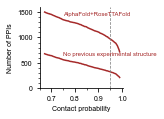

In [7]:
# do size, with and without previous structures
x = np.linspace(afrf['PPI Score'].min(), 0.99, 100)
n = [(afrf['PPI Score'] >= i).sum() for i in x]
n_new = [((afrf['PPI Score'] >= i) & (afrf['PDB_complex'] == 'na')).sum() for i in x]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.5, 1.5)
ax.plot(x, n, color=COLOR_ALPHAFOLD_ROSETTAFOLD)
ax.plot(x, n_new, color=COLOR_ALPHAFOLD_ROSETTAFOLD)
ax.set_ylim(0, 1600)
ax.axvline(x=0.95, color='grey', linestyle='--', linewidth=0.75)
ax.set_xlabel('Contact probability')
ax.set_ylabel('Number of PPIs')
ax.text(x=0.75, y=1400, s='AlphaFold+RoseTTAFold', va='bottom', ha='left', color=COLOR_ALPHAFOLD_ROSETTAFOLD, fontsize=6)
ax.text(x=0.75, y=620, s='No previous experimental structure', va='bottom', ha='left', color=COLOR_ALPHAFOLD_ROSETTAFOLD, fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(np.linspace(0.7, 1., 4))
ax.set_xticks(np.linspace(0.65, 1., 8), minor=True)
ax.set_yticks(np.linspace(0, 1500, 4))
ax.set_yticks(np.linspace(0, 1500, 16), minor=True)
fig.savefig('../figures/AlphaFoldRoseTTAFold_size-by-cutoff.pdf',
            bbox_inches='tight')

In [8]:
def load_yeast_transmembrane_proteins():
    df = pd.read_csv('../data/external/uniprotkb_organism_id_4932_AND_keyword_KW-0812_2023_07_24.tsv',
                    sep='\t')
    gene_names = set(df['Gene Names (primary)'].str.upper().dropna().unique())
    orfs = load_all_orfs()
    return set(orfs.loc[orfs['gene_name'].isin(gene_names) |
            orfs['orf_name'].isin(gene_names),
            'orf_name'].values)


tm_orfs = load_yeast_transmembrane_proteins()

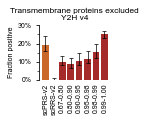

In [9]:
afr_no_tm = afrf.loc[(afrf['orf_name_a'].isin(tm_orfs) == False) & 
                     (afrf['orf_name_b'].isin(tm_orfs) == False), :].copy()
bins = [(afr_no_tm['PPI Score'].min(), 0.8),
        (0.8, 0.9),
        (0.9, 0.95),
        (0.95, 0.98),
        (0.98, 0.99),
        (0.99, 1.)]

# find pairs with low confidence
ns = [((afr_no_tm['PPI Score'] > a) & (afr_no_tm['PPI Score'] <= b) &
                   (afr_no_tm['S07_source_datasets'] != 'YeRI') &
                   afr_no_tm['Y2H_v4_result'].isin(['Negative', 'Positive'])).sum() for a, b in bins]
ps = [((afr_no_tm['PPI Score'] > a) & (afr_no_tm['PPI Score'] <= b) &
                   (afr_no_tm['S07_source_datasets'] != 'YeRI') &
                   (afr_no_tm['Y2H_v4_result'] == 'Positive')).sum() for a, b in bins]


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.3, h=1)
validation_plot(positives=[PRS_combined_rate * min([n_PRS_tested_S07, n_PRS_tested_S08]),
                           0] + ps,
                n_tested=[min([n_PRS_tested_S07, n_PRS_tested_S08]),
                          min([n_RRS_tested_S07, n_RRS_tested_S08])] + ns,
                draw_numbers=False,
                labels=['scPRS-v2', 'scRRS-v2'] + ['{:.2f}-{:.2f}'.format(a, b) for (a, b) in bins],
                y_max=0.3,
                colors=[COLOR_PRS, COLOR_RRS] + [COLOR_ALPHAFOLD_ROSETTAFOLD] * len(bins),
                xlabel_rotation=90,
                errorbar_capsize=0.5,
                errorbar_thickness=0.7,
                ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_facecolor('white')
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
ax.set_title('Transmembrane proteins excluded\nY2H v4')
fig.savefig('../figures/TM-excluded_S07-plus-S08-merge_confidence-binned_AlphFoldRoseTTAFold.pdf',
            bbox_inches='tight')

In [10]:
prs_n = min([n_PRS_tested_S07, n_PRS_tested_S08])
prs_p = PRS_combined_rate * prs_n
for p, n in zip(ps, ns):
    print(
        stats.fisher_exact([[p, n - p], [prs_p, prs_n - prs_p]], alternative='less')
    )

SignificanceResult(statistic=0.46044444444444443, pvalue=0.03316496236105984)
SignificanceResult(statistic=0.3915343915343915, pvalue=0.01948204760642965)
SignificanceResult(statistic=0.48366013071895425, pvalue=0.06298904906418187)
SignificanceResult(statistic=0.5409356725146199, pvalue=0.10570296369858706)
SignificanceResult(statistic=0.7321156773211568, pvalue=0.2800800083925463)
SignificanceResult(statistic=1.3778383287920073, pvalue=0.8999304544000832)
